# Prediction of Active Enhancers with FFNN

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from itertools import product
from typing import List
from tqdm.auto import tqdm
#from keras_tqdm import TQDMNotebookCallback as ktqdm
from multiprocessing import cpu_count
import compress_json
import os
from barplots import barplots
from tensorflow.keras.layers import Layer, Input, Flatten, Reshape, Dense, Conv2D, BatchNormalization, Activation, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import AUC

In [11]:
from epigenomic_dataset import load_epigenomes
from sklearn.impute import KNNImputer
from sklearn.preprocessing import RobustScaler

# The considered window size
window_size = 200

# Retrieving the input data
X, y = load_epigenomes(
    cell_line = "HEK293",
    dataset = "fantom",
    regions = "promoters",
    window_size = window_size
)

y = y.values.ravel()

# Imputation of NaN Values
X[X.columns] = KNNImputer(n_neighbors=X.shape[0]//10).fit_transform(X)

# Robust normalization of the values
X[X.columns] = RobustScaler().fit_transform(X)

X = X.values

# Here one should feature selection. How can we do this?

## Models

In [16]:
models = []
kwargs = []

### Decision Trees

In [12]:
from sklearn.tree import DecisionTreeClassifier

decision_tree = DecisionTreeClassifier(
    criterion="gini",  # criterio di gini è tale per cui per ogni step scelgo la feature più discriminante rispetto ai dati
    max_depth=50, #max 2^50 foglie, max 50 split -> grande, soggetto a overfitting.
    random_state=42, #per rendere rimproducibile l'esecuzione dell'albero
    class_weight="balanced" #per evitare il "miss predizione" di una classe, per sbilanciamento di classi
)

models.append(decision_tree)
kwargs.append({})

### Decision Tree 2

voglio ridurre l'overfitting. ammorbidisco il modello!

cambio max_depth

In [4]:
from sklearn.tree import DecisionTreeClassifier

decision_tree = DecisionTreeClassifier(
    criterion="gini",  
    max_depth=10, #abbasso a 10
    random_state=42, 
    class_weight="balanced" 
)

models.append(decision_tree)
kwargs.append({})

### Random forests

In [5]:
from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier(
    n_estimators=500, #500 alberi
    criterion="gini", 
    max_depth=30, #max 30 split
    random_state=42,
    class_weight="balanced",
    n_jobs=cpu_count() #numero di tuning in parallelo: ottimizzazioni in parallelo degl alberi
)

models.append(random_forest)
kwargs.append({})

### Perceptron

In [17]:
#non è proprio un percettrone: perché la loss e l'aggiornamento dei pesi non è banale.
# è un livello denso con un neurone. => più semplice modello con keras di rete neutrale
#in alcuni casi è sufficiente per la classificazione senza modelli più complessi
#quando dichiaro in un paper che un modello va meglio => più è semplice meglio è! Occam Razor!!!!!!

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.callbacks import EarlyStopping


perceptron = Sequential([
    Input(shape=(207, )), #shape di input del dataset
    Dense(1, activation="sigmoid") #attivazione sigmoide
], "Perceptron")

perceptron.compile(
    optimizer="nadam", #magari altri rispetto nadam va meglio
    loss="binary_crossentropy"  #è una classificazione
)

models.append(perceptron)
kwargs.append(dict(
    epochs=1000,
    batch_size=1024,
    validation_split=0.1,
    shuffle=True,
    verbose=False,
    callbacks=[
        EarlyStopping(monitor="val_loss", mode="min", patience=50),
        ktqdm(leave_outer=False)
    ]
))  #aggiungo informazione aggiuntive, batch size arbitraria. 

### Multi-Layer Perceptron (MLP)

In [17]:
#cascata di layer dens
#differenza tra MLP e FFNN è un sottile. FFNN se inserirsco layer che non sono solo densi
#MLP tanti percettroni a più livelli
#FNN non solo

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

mlp = Sequential([
    Input(shape=(104, )),
    Dense(128, activation="relu"),
    Dense(64, activation="relu"),
    Dense(32, activation="relu"),
    Dense(1, activation="sigmoid")
], "MLP")

mlp.compile(
    optimizer="nadam",
    loss="binary_crossentropy"
)

models.append(mlp)
kwargs.append(dict(
    epochs=1000,
    batch_size=1024,
    validation_split=0.1,
    shuffle=True,
    verbose=False,
    callbacks=[
        EarlyStopping(monitor="val_loss", mode="min", patience=50)
    ]
))

NameError: name 'ktqdm' is not defined

### Feed-Forward Neural Network (FFNN)

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Activation, Dropout


ffnn = Sequential([
    Input(shape=(104, )),
    Dense(256, activation="relu"),
    Dense(128),
    BatchNormalization(),  #in più rispetto MLP: procedura tc durante il training, 
    #quando arriva un batch questo viene normalizzato su media e varianza su asse del batch. Z-scoring sul batch
    Activation("relu"),
    Dense(64, activation="relu"),
    Dropout(0.3), #in più rispetto MLP: impatta molto sulle reti. durante training disabilita una percentuale di neuroni al 
    #livello precedente. PEr esempio prima ho 64 neuroni, ad ogni epoch una percetuale di questi 64 viene spenta
    #Induce il modello a creare un ensamble di classificatori, cioè il modello non può far uso di tutti i neuroni allo stesso modello
    #utile quando il modello è caratterizzato da overfitting. Se non sto apprendendo i valori di training, il dropout fa danni. 
    #deve apprendere bene i valori di training
    Dense(32, activation="relu"),
    Dense(16, activation="relu"),
    Dense(1, activation="sigmoid")
], "FFNN")

ffnn.compile(
    optimizer="nadam",
    loss="binary_crossentropy"
)

models.append(ffnn)
kwargs.append(dict(
    epochs=1000,
    batch_size=1024,
    validation_split=0.1, #dei dati di training ne uso 10% per la validazione
    shuffle=True,
    verbose=False,
    callbacks=[
        EarlyStopping(monitor="val_loss", mode="min", patience=50),
        ktqdm(leave_outer=False)
    ]
))

ffnn.summary()

Model: "FFNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 256)               26880     
_________________________________________________________________
dense_6 (Dense)              (None, 128)               32896     
_________________________________________________________________
batch_normalization (BatchNo (None, 128)               512       
_________________________________________________________________
activation (Activation)      (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 32)                2080   

# FFNN2

Come miglioro il modello?

cambiare l'attivazione non è molto utile! serve per analizzare dati molto sparsi.
una volta consolidato, non serve cambiare!
Ex: tesla usa solo Relu in una DNN molto profonda

Primo approccio:
esploro prima l'idea di esplorare strutture diverse

la FFNN1 funzionava bene sul training, volevamo migliorare il test.
aggiungo uno strato     Dense(64, activation="relu"), prima del drop out

aumento il drop out a 05

raddoppio la sezione di drop out (la faccio fare 2 volte, ma con strati con meno neuroni da 64 a 32)


in più il mio prima modello si fermava sempre nel training. modifico i parametri del EarlyStopping

Dato che EarlyStopping finisce presto potrebbe essere una buona idea semplificare di molto il livello!
1) diminuire strati e livelli
2) più simile a MLP e anche semplificato

Potrei aumentare ancora di più il dropout

abbiamo visto che funziona peggio!!!!
c'è meno overfitting, ma la performance è peggiore!


In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Activation, Dropout


ffnn2 = Sequential([
    Input(shape=(104, )),
    Dense(256, activation="relu"),
    Dense(128),
    BatchNormalization(),  
    Activation("relu"),
    Dense(64, activation="relu"),
    Dense(64, activation="relu"), #in più
    Dropout(0.5), #aumento da 0,3 a 0,5
    Dense(32, activation="relu"), #raddoppio abbassando da 64 a 32
    Dense(32, activation="relu"),
    Dropout(0.5), 
    Dense(32, activation="relu"),
    Dense(16, activation="relu"),
    Dense(1, activation="sigmoid")
], "FFNN2")

ffnn2.compile(
    optimizer="nadam",
    loss="binary_crossentropy"
)

models.append(ffnn2)
kwargs.append(dict(
    epochs=1000,
    batch_size=1024,
    validation_split=0.1, 
    shuffle=True,
    verbose=False,
    callbacks=[
        EarlyStopping(monitor="val_loss", mode="min", patience=70, restore_best_weights=True), 
        #aumento pazienza da 50 a 70
        #aggiungo restore_best_weights: quando fermo il testo, lo ripristino quello che per la validation loss era il migliore
        ktqdm(leave_outer=False)
    ]
))

ffnn2.summary()

Model: "FFNN2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 256)               26880     
_________________________________________________________________
dense_12 (Dense)             (None, 128)               32896     
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
activation_1 (Activation)    (None, 128)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_14 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0     

## Meta-models
Meta-models are models that generate models: this means that, usually, they define hyper-parameters space that are then explored through some (tipically iterative) procedure using some defined score to optimize for choosing the best possible model. Depending on the kind of hyper-parameters exploration to intend to do, you might choose a different method.

Often this kind of optimization are executed on clusters, expecially when tackling the space of structures of neural networks, so for now I will limit to show some of the alternatives without actually running the optimization.

Other important and useful methods are the [Tree of Parzen](https://github.com/hyperopt/hyperopt) and [Bayesian Optimization](https://github.com/fmfn/BayesianOptimization), but I could not manage to fit them within this lesson.


#### METODI Per imparare IperParamentri per un certo modello. Molto utilizzati ma richeidono ampio tempo di calcolo, nel progetto si può pensare di usarli. Ma potrebbe anche non essere necessario!


### Grid search
A grid search is just that: you define a grid of hyper-parameters to explore (for instance for two hyper-parameters with 8 available options you get a chess-board of possible combinations) and iteratively you start, one by one (or in parallel) to explore each possible combination.

When the time required by the fit of the model is not a lot and the combination of possible parameters are not that many, one can thing about doing am exhaustive Grid Search.

Tipically, in a cluster scenario, you would run a combination on each available cluster node in parallel.

#### Grid search with Sklearn
Our loyal friend Sklearn, as many other times, has us covered also for a [simple implementation of a Grid Search](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) (that can also be simply implemented by a product of the hyper-parameters space and a for loop). You can use their implementation as follows:

In [61]:
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV

iris = datasets.load_iris()
parameters = dict(
    max_depth=[2, 10, 20, 50, None],
    class_weight=[None, "balanced"]
)
grid = GridSearchCV(DecisionTreeClassifier(), parameters, scoring="balanced_accuracy")
grid.fit(iris.data, iris.target)

print(grid.best_params_, grid.best_score_)

{'class_weight': None, 'max_depth': 10} 0.9666666666666668


#### Distributed grid search with Ray
[Ray](https://github.com/ray-project/ray) is a library for, among other things, running distributed hyper-parameters search. It supports all the methods presented in this lesson, and can be used in multiple settings, from on your own computer for a parallel search up to computation clusters.

Here the version proposed is equivalent to the one used in Sklearn, but can be scaled. You can reasonably think to setup a Ray cluster on your machines if they are comparable in hardware terms for running part of your project if you consider using this hyper-parameters search solution.

In [62]:
from ray import tune
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score

def train(config):
    X, y = datasets.load_iris(return_X_y=True)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    tree = DecisionTreeClassifier(**config)
    tree.fit(X_train, y_train)
    tune.track.log(balanced_accuracy_score=balanced_accuracy_score(y_test, tree.predict(X_test)))


analysis = tune.run(
    train, config = dict(
        max_depth=tune.grid_search([2, 10, 20, 50, None]),
        class_weight=tune.grid_search([None, "balanced"])
    )
)

print("Best config: ", analysis.get_best_config(metric="balanced_accuracy_score"))

# Get a dataframe for analyzing trial results.
df = analysis.dataframe()

ModuleNotFoundError: No module named 'ray'

### Random search
A random search is another approach for identifying an optimal set of hyper-parameters. It is a good alternative to grid search when either the time required to fit a model is really high or the hyper-parameters space is very huge.

[Grid search can be outperformed by random search in these settings](http://www.jmlr.org/papers/v13/bergstra12a.html).

As for grid search, also random search is vastly parallelizable and can be run in clusters.

A significant difference between grid search and random search, is that random search can also sample random points from a continuos distribution, whereas grid search will turn the continuos distribution into a discrete one by sampling it uniformely.

#### Random search with Sklearn
As before, [we can use the implementation from Sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html).

In [63]:
from sklearn import svm, datasets
from sklearn.model_selection import RandomizedSearchCV

iris = datasets.load_iris()
parameters = dict(
    max_depth=[2, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, None],
    class_weight=[None, "balanced"]
)
random_search = RandomizedSearchCV(DecisionTreeClassifier(), parameters, scoring="balanced_accuracy", n_iter=10)
random_search.fit(iris.data, iris.target)

print(random_search.best_params_, random_search.best_score_)

{'max_depth': 65, 'class_weight': 'balanced'} 0.9666666666666668


## The experimental setup
After having **well defined** the models we intend to explore, we have to define how we intend to evaluate them, the data used and basically **ALL** the tiny seeming uninportant aspects that we will keep in consideration.

This part is **VERY** important and will help you avoid loosing a lot of time caused by reinveinting the wheel or making beginners' mistakes. 

If it is not already clear, **BEFORE WRITING A SINGLE LINE OF CODE WRITE YOUR EXPERIMENTAL SETUP IN YOUR PROJECT**. Here I showed you the models in code to help you understand them, but in a paper or in the project you should descrive the models you intend to explore in writing.

### Voglio vedere che tra i modelli la FFNN per la predizione degli enancher attivi per la linea cellulare GM12878 per la window_size di 200 nucleotidi funziona meglio. Verifichiamo usando una 50-fold cross validation

That said, let's begin: we will evaluate the models we have defined on the enhancers epigenomic dataset, using a 50-fold cross validation. 



## Retrieving the data

In [10]:
from epigenomic_dataset import load_epigenomes
from sklearn.impute import KNNImputer
from sklearn.preprocessing import RobustScaler

# The considered window size
window_size = 200

# Retrieving the input data
X, y = load_epigenomes(
    cell_line = "HEK293",
    dataset = "fantom",
    regions = "enhancers",
    window_size = window_size
)

y = y.values.ravel()

# Imputation of NaN Values
X[X.columns] = KNNImputer(n_neighbors=X.shape[0]//10).fit_transform(X)

# Robust normalization of the values
X[X.columns] = RobustScaler().fit_transform(X)

X = X.values

# Here one should feature selection. How can we do this?

## Preparing the holdouts

In [11]:
from sklearn.model_selection import StratifiedShuffleSplit

splits = 50
holdouts = StratifiedShuffleSplit(n_splits=splits, test_size=0.2, random_state=42)

# sto usando 50 diverse e randomiche suddivisioni del data set 20(test) - 80(learning)

## Training the models

In [18]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score, roc_auc_score, average_precision_score
from sanitize_ml_labels import sanitize_ml_labels

def report(y_true:np.ndarray, y_pred:np.ndarray)->np.ndarray:
    integer_metrics = accuracy_score, balanced_accuracy_score
    float_metrics = roc_auc_score, average_precision_score
    results1 = {
        sanitize_ml_labels(metric.__name__): metric(y_true, np.round(y_pred))
        for metric in integer_metrics
    }
    results2 = {
        sanitize_ml_labels(metric.__name__): metric(y_true, y_pred)
        for metric in float_metrics
    }
    return {
        **results1,
        **results2
    }

#si usano solo per categorizzazione, non hanno senso per regressione
# auroc: area sotto la curva di Receiver operating characteristic: analizza falsi positivi e negativi
# valore minimo è 0.5 (non impara niente)  valore massimo è 1 (modello perfetto)
# auprc: area sotto la curva di precision recall: va a computare per diversi treashold di precisioni diversi, la somma delle aree
#sottese sotto i diversi traingolini della precision-reacall. Un modello che non impara nulla ha AUPRC = 0 e un modello perfetto ha
# AUPRC = 1

In [19]:
def precomputed(results, model:str, holdout:int)->bool:
    df = pd.DataFrame(results)
    if df.empty:
        return False
    return (
        (df.model == model) &
        (df.holdout == holdout)
    ).any()

In [20]:
import json
#if os.path.exists("results1.json"):
 #   with open('results.json') as json_file:
#        results = json.load(json_file)
#else:
results = []
    
for i, (train, test) in tqdm(enumerate(holdouts.split(X, y)), total=splits, desc="Computing holdouts", dynamic_ncols=True):
    for model, params in tqdm(zip(models, kwargs), total=len(models), desc="Training models", leave=False, dynamic_ncols=True):
        model_name = (
            model.__class__.__name__
            if model.__class__.__name__ != "Sequential"
            else model.name
        )
        if precomputed(results, model_name, i):
            continue
        print( model_name)
        model.fit(X[train], y[train], **params)
        results.append({
            "model":model_name,
            "run_type":"train",
            "holdout":i,
            **report(y[train], model.predict(X[train]))
        })
        results.append({
            "model":model_name,
            "run_type":"test",
            "holdout":i,
            **report(y[test], model.predict(X[test]))
        })
       # compress_json.local_dump(results, "results.json")

Perceptron


Perceptron


Perceptron


Perceptron


Perceptron


Perceptron


Perceptron


Perceptron


Perceptron


Perceptron


Perceptron


Perceptron


Perceptron


Perceptron


Perceptron


Perceptron


Perceptron


Perceptron


Perceptron


Perceptron


Perceptron


Perceptron


Perceptron


Perceptron


Perceptron


Perceptron


Perceptron


Perceptron


Perceptron


Perceptron


Perceptron


Perceptron


Perceptron


Perceptron


Perceptron


Perceptron


Perceptron


Perceptron


Perceptron


Perceptron


Perceptron


Perceptron


Perceptron


Perceptron


Perceptron


Perceptron


Perceptron


Perceptron


Perceptron


Perceptron


## Collecting the results

In [69]:
df = pd.DataFrame(results)
df = df.drop(columns=["holdout"])
df[:5]

,model,run_type,Accuracy,Balanced Accuracy,AUROC,AUPRC
0,DecisionTreeClassifier,train,0.999943,0.999960,0.999960,0.999795
1,DecisionTreeClassifier,test,0.749943,0.689828,0.689828,0.430826
2,RandomForestClassifier,train,1.000000,1.000000,1.000000,1.000000
3,RandomForestClassifier,test,0.826137,0.729755,0.729755,0.542366
4,Perceptron,train,0.829149,0.733567,0.850571,0.755466


In [70]:
barplots(
    df,
    groupby=["model", "run_type"],
    show_legend=False,
    height=5,
    orientation="horizontal"
)

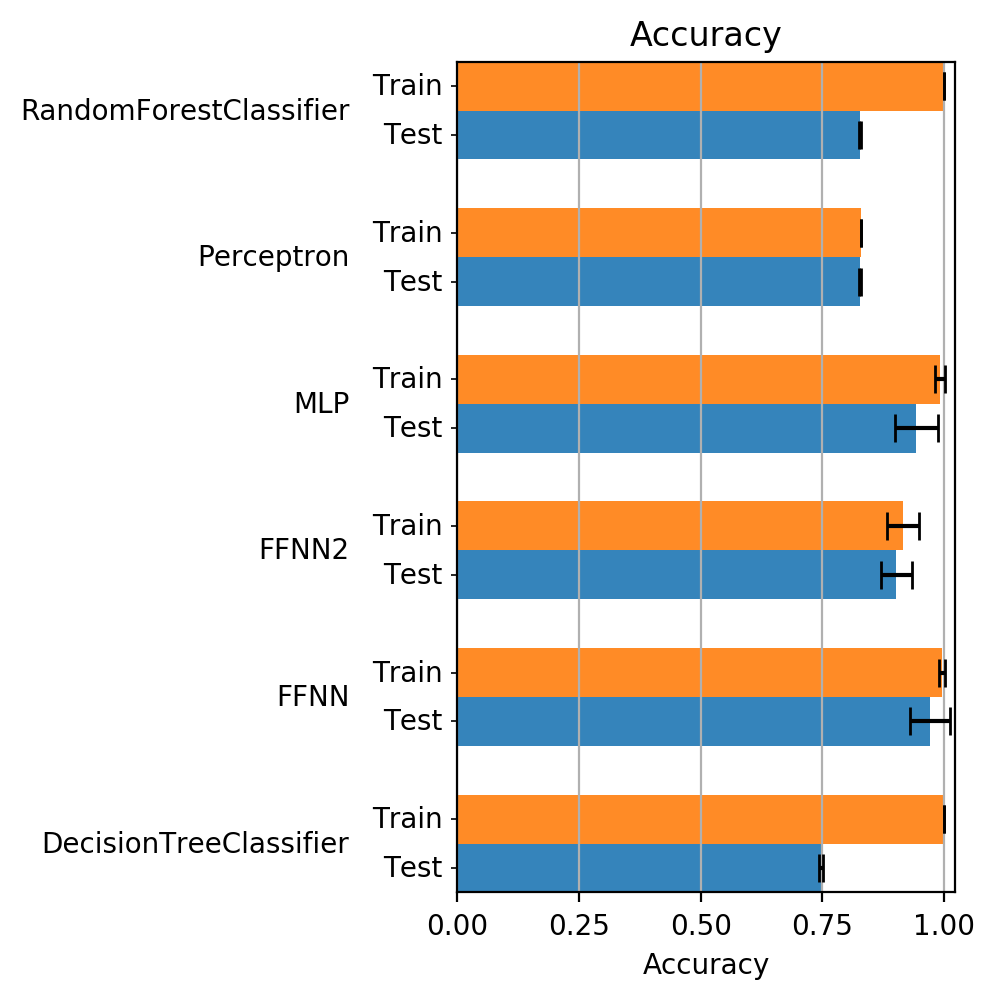

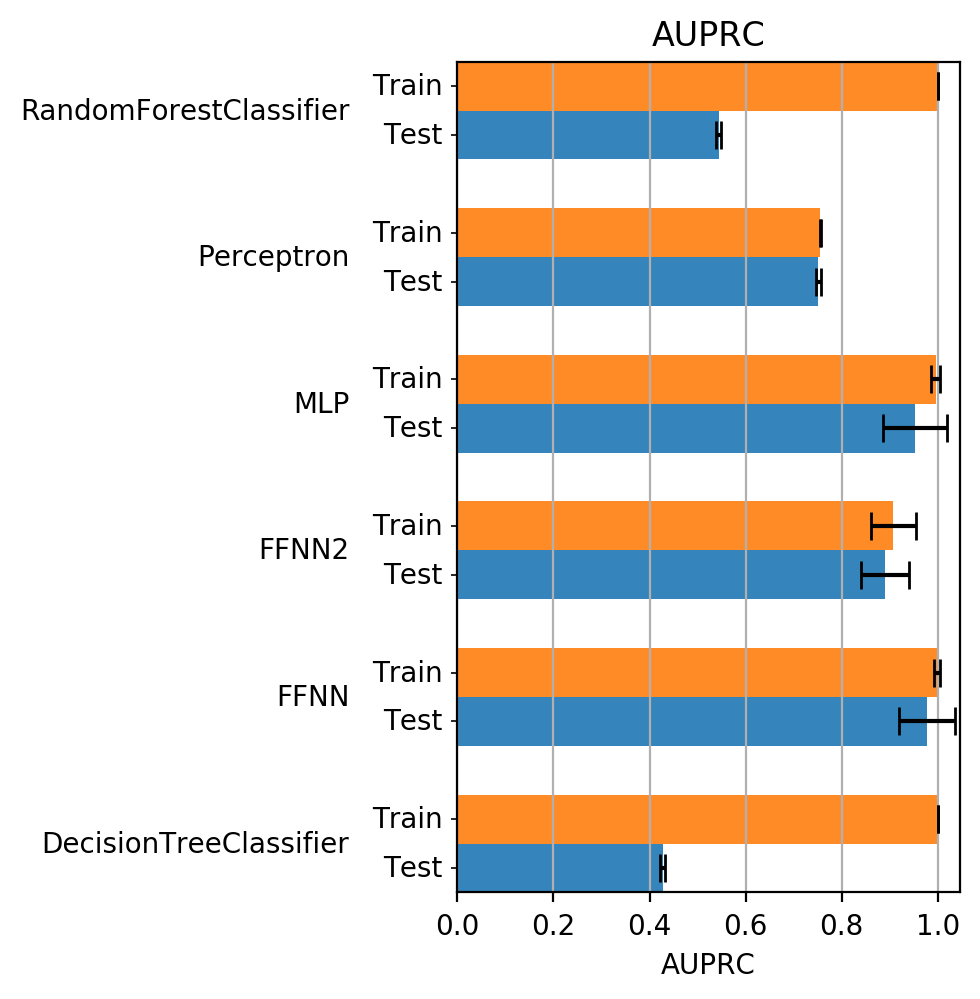

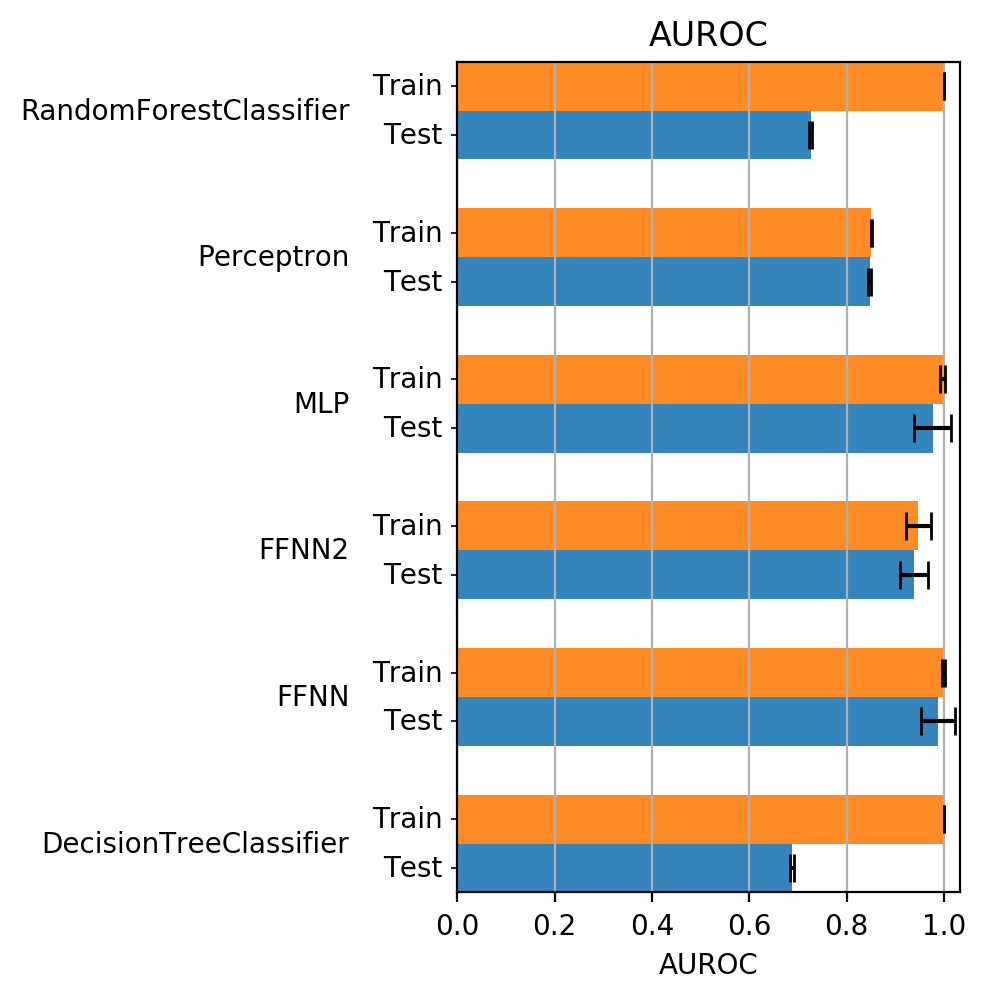

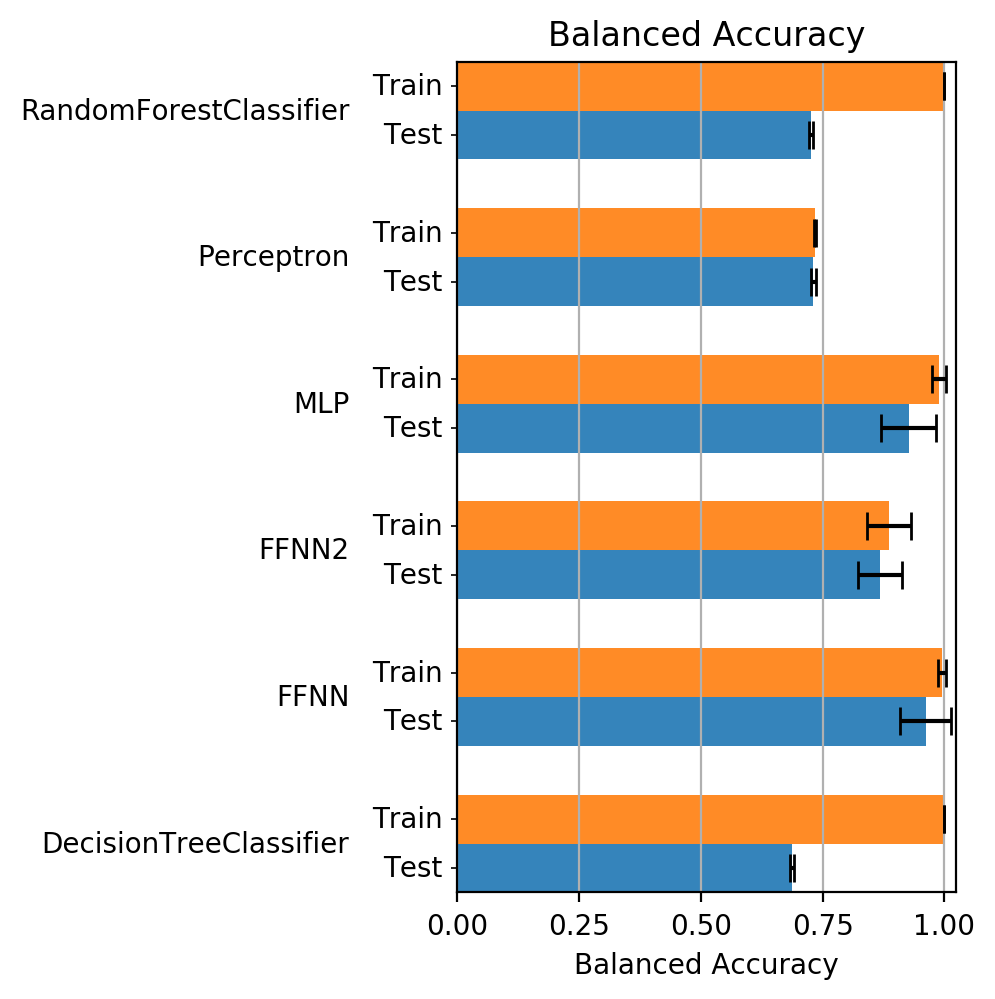

In [71]:
from PIL import Image
from glob import glob

for x in glob("barplots/*.png"):
    display(Image.open(x))

## Statistical tests
To compare the obtained results in a statistically valid manner we need to run a statistical tests. 

### FFNN simile a MLP, voglio capire se FFNN è veramente meglio di MLP

Here we will use a Wilcoxon signed-rank test, with p-value $0.01$.

In [72]:
from scipy.stats import wilcoxon

# Here we will be doing a statistical test.


#ipostesi: FFNN e MLP hanno distribuzione diversa
#ipotesi nulla: FFNN e MLP stessa distribuzione
#se il p-value che trovo è > 0.01 accetto ipotesi nulla
models = df[
    (df.model.isin(["MLP","FFNN"])) &
    (df.run_type == "test")  #dati relativi al test set
]


ffnn_scores = models[models.model=="FFNN"]
mlp_scores = models[models.model=="MLP"]

#per ogni metrica faccio un test
alpha = 0.01
for metric in ffnn_scores.columns[-4:]:
    print(metric)
    a,b = ffnn_scores[metric],mlp_scores[metric]
    stats, p_value=wilcoxon(a, b)
    if p_value>alpha:
        print(p_value,"2 models performances are statistically identical.")
    else:
        print(p_value,"2 models performances are statistically different.")
        if a.mean()>b.mean():
            print("The fist model is better")
        else:
            print("The second model is better")

Accuracy
5.145276051717656e-10 2 models performances are statistically different.
The fist model is better
Balanced Accuracy
5.145276051717656e-10 2 models performances are statistically different.
The fist model is better
AUROC
2.6464028636782697e-09 2 models performances are statistically different.
The fist model is better
AUPRC
1.873720628687333e-09 2 models performances are statistically different.
The fist model is better


In [36]:
from scipy.stats import wilcoxon

# Here we will be doing a statistical test.
#ipostesi: FFNN e MLP hanno distribuzione diversa
#ipotesi nulla: FFNN e MLP stessa distribuzione
#se il p-value che trovo è > 0.01 accetto ipotesi nulla
models = df[
    (df.model.isin(["MLP","FFNN"])) &
    (df.run_type == "train")  #dati relativi al train test
]


ffnn_scores = models[models.model=="FFNN"]
mlp_scores = models[models.model=="MLP"]

#per ogni metrica faccio un test
alpha = 0.01
for metric in ffnn_scores.columns[-4:]:
    print(metric)
    a,b = ffnn_scores[metric],mlp_scores[metric]
    stats, p_value=wilcoxon(a, b)
    if p_value>alpha:
        print(p_value,"2 models performances are statistically identical.")
    else:
        print(p_value,"2 models performances are statistically different.")
        if a.mean()>b.mean():
            print("The fist model is better")
        else:
            print("The second model is better")

Accuracy
7.346715519271017e-10 2 models performances are statistically different.
The fist model is better
Balanced Accuracy
5.230436547599727e-09 2 models performances are statistically different.
The fist model is better
AUROC
1.6688726584419227e-09 2 models performances are statistically different.
The fist model is better
AUPRC
1.6688726584419227e-09 2 models performances are statistically different.
The fist model is better


### Potrei avere degli outliers nelle metriche che creano variabilità e rendono l'intervallo di confidenza per la media molto ampio

In [34]:
from scipy.stats import wilcoxon

# Here we will be doing a statistical test.
#ipostesi: Percettrone e MLP hanno distribuzione diversa
#ipotesi nulla: Percettrone e MLP stessa distribuzione
#se il p-value che trovo è > 0.01 accetto ipotesi nulla
models = df[
    (df.run_type == "test")
]


perceptron_scores = models[models.model=="Perceptron"]
mlp_scores = models[models.model=="MLP"]

#per ogni metrica faccio un test
alpha = 0.01
for metric in perceptron_scores.columns[-4:]:
    print(metric)
    a,b = perceptron_scores[metric],mlp_scores[metric]
    stats, p_value=wilcoxon(a, b)
    if p_value>alpha:
        print(p_value,"2 models performances are statistically identical.")
    else:
        print(p_value,"2 models performances are statistically different.")
        if a.mean()>b.mean():
            print("The fist model is better")
        else:
            print("The second model is better")

Accuracy
3.5203948944794863e-09 2 models performances are statistically different.
The second model is better
Balanced Accuracy
8.271870119246836e-10 2 models performances are statistically different.
The second model is better
AUROC
1.5748039913260536e-09 2 models performances are statistically different.
The second model is better
AUPRC
2.6464028636782697e-09 2 models performances are statistically different.
The second model is better


In [35]:
from scipy.stats import wilcoxon

# Here we will be doing a statistical test.
#ipostesi: Percettrone e Albero hanno distribuzione diversa
#ipotesi nulla: Percettrone e Albero stessa distribuzione
#se il p-value che trovo è > 0.01 accetto ipotesi nulla
models = df[
    (df.run_type == "test")
]


perceptron_scores = models[models.model=="Perceptron"]
tree_scores = models[models.model=="DecisionTreeClassifier"]

#per ogni metrica faccio un test
alpha = 0.01
for metric in perceptron_scores.columns[-4:]:
    print(metric)
    a,b = perceptron_scores[metric],tree_scores[metric]
    stats, p_value=wilcoxon(a, b)
    if p_value>alpha:
        print(p_value,"2 models performances are statistically identical.")
    else:
        print(p_value,"2 models performances are statistically different.")
        if a.mean()>b.mean():
            print("The fist model is better")
        else:
            print("The second model is better")

Accuracy
5.141922487820913e-10 2 models performances are statistically different.
The fist model is better
Balanced Accuracy
5.145276051717656e-10 2 models performances are statistically different.
The fist model is better
AUROC
5.145276051717656e-10 2 models performances are statistically different.
The fist model is better
AUPRC
5.145276051717656e-10 2 models performances are statistically different.
The fist model is better


In [73]:
from scipy.stats import wilcoxon

# Here we will be doing a statistical test.
#ipostesi: Percettrone e Albero hanno distribuzione diversa
#ipotesi nulla: Percettrone e Albero stessa distribuzione
#se il p-value che trovo è > 0.01 accetto ipotesi nulla
models = df[
    (df.run_type == "test")
]


ffnn_scores = models[models.model=="FFNN"]
ffnn2_scores = models[models.model=="FFNN2"]

#per ogni metrica faccio un test
alpha = 0.01
for metric in perceptron_scores.columns[-4:]:
    print(metric)
    a,b = ffnn_scores[metric],ffnn2_scores[metric]
    stats, p_value=wilcoxon(a, b)
    if p_value>alpha:
        print(p_value,"2 models performances are statistically identical.")
    else:
        print(p_value,"2 models performances are statistically different.")
        if a.mean()>b.mean():
            print("The fist model is better")
        else:
            print("The second model is better")

Accuracy
6.526964088358432e-10 2 models performances are statistically different.
The fist model is better
Balanced Accuracy
5.461520578031993e-10 2 models performances are statistically different.
The fist model is better
AUROC
4.673006480160376e-09 2 models performances are statistically different.
The fist model is better
AUPRC
2.9671656946762475e-09 2 models performances are statistically different.
The fist model is better


In [74]:
from scipy.stats import wilcoxon

# Here we will be doing a statistical test.
#ipostesi: Percettrone e Albero hanno distribuzione diversa
#ipotesi nulla: Percettrone e Albero stessa distribuzione
#se il p-value che trovo è > 0.01 accetto ipotesi nulla
models = df[
    (df.run_type == "train")
]


ffnn_scores = models[models.model=="FFNN"]
ffnn2_scores = models[models.model=="FFNN2"]

#per ogni metrica faccio un test
alpha = 0.01
for metric in perceptron_scores.columns[-4:]:
    print(metric)
    a,b = ffnn_scores[metric],ffnn2_scores[metric]
    stats, p_value=wilcoxon(a, b)
    if p_value>alpha:
        print(p_value,"2 models performances are statistically identical.")
    else:
        print(p_value,"2 models performances are statistically different.")
        if a.mean()>b.mean():
            print("The fist model is better")
        else:
            print("The second model is better")

Accuracy
5.145276051717656e-10 2 models performances are statistically different.
The fist model is better
Balanced Accuracy
5.145276051717656e-10 2 models performances are statistically different.
The fist model is better
AUROC
5.145276051717656e-10 2 models performances are statistically different.
The fist model is better
AUPRC
5.145276051717656e-10 2 models performances are statistically different.
The fist model is better
